In [27]:
from __future__ import print_function
import time, os, json
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt

from util import *
from model.video_caption import sequence_2_sequence_LSTM
from model.image_caption import image_caption_LSTM

from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Build Model

In [99]:
#=======Change These===============================
max_train = 40000
word_vector_size = 50
#==================================================


data = load_coco_data(pca_features = False, max_train = max_train)
input_size = data['train_features'].shape[1]
maxLen = data['train_captions'].shape[1]
wordLs = []

for caption in data['train_captions']:
    for word in caption:
        wordLs.append(word)
voc_size = len(list(set(wordLs)))

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))
print('\ninput_size:', input_size, ' maxLen:', maxLen, ' voc_size:', voc_size)
print('Finish loading training data!')

train_image_idxs <class 'numpy.ndarray'> (40000,) int32
train_urls <class 'numpy.ndarray'> (82783,) <U63
train_captions <class 'numpy.ndarray'> (40000, 17) int32
val_features <class 'numpy.ndarray'> (40504, 4096) float32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
idx_to_word <class 'list'> 1004
train_features <class 'numpy.ndarray'> (82783, 4096) float32
word_to_idx <class 'dict'> 1004
val_urls <class 'numpy.ndarray'> (40504,) <U63
val_image_idxs <class 'numpy.ndarray'> (195954,) int32

input_size: 4096  maxLen: 17  voc_size: 1004
Finish loading training data!


In [100]:
# create word2ind and ind2word dictionary
index2Word_ori = data['idx_to_word']
word2Index_ori = data['word_to_idx']

wordLs = sorted(list(set(wordLs)))
word2index = {}
index2word = {}
for i, word_ind in enumerate(wordLs):
    word = index2Word_ori[word_ind]
    word2index[word] = i
    index2word[i] = word
print('finish building dictionary')

finish building dictionary


build model

In [101]:
captions_train = {}
captions_corresponding_videoIds = []
input_frames_train = {}

captions_corresponding_videoIds = data['train_image_idxs']
for i, ind in enumerate(data['train_image_idxs']):
    caption = data['train_captions'][i]
    caption_new = []
    for word_ind in caption:
        word = index2Word_ori[word_ind]
        caption_new.append( word2index[word] )
        
    captions_train[ind] = list(caption_new)
    input_frames_train[ind] = data['train_features'][ind].reshape(1, input_size)

word_embedding = np.random.randn(voc_size, word_vector_size).astype(np.float32)

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

In [102]:
# define parameters
logging.basicConfig(level=logging.INFO)
#=======Change These===============================
state_size = 1024
#==================================================

tf.app.flags.DEFINE_string("model_name", "sequence2sequence", "name of the model")
tf.app.flags.DEFINE_integer("state_size", state_size, "Size of each model layer.")
tf.app.flags.DEFINE_float("input_size", 4096, "input size for each frame")
tf.app.flags.DEFINE_integer("max_sentence_length", 17, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", word_vector_size, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("num_frames", 1, "number of frames per video")
FLAGS = tf.app.flags.FLAGS        

ArgumentError: argument --model_name: conflicting option string: --model_name

In [103]:
# build model graph
tf.reset_default_graph()
#=======Change These===============================
batch_size = 64
epoch = 40
lr = 1e-5
hidden_size = 1024
#==================================================

model = image_caption_LSTM(word_embedding, FLAGS, batch_size=batch_size, hidden_size=hidden_size,
        voc_size = voc_size, n_epochs = epoch, lr = lr, reg = 1e-3, save_model_file = 'COCO')

# model = sequence_2_sequence_LSTM(word_embedding, FLAGS, batch_size=batch_size, hidden_size=hidden_size,
#         voc_size = voc_size, n_epochs = epoch, lr = lr, reg = 1e-3, mode = 'train', save_model_file = 'COCO')


model.train_embedding = True
model.build()

start building model ...
total number of parameter 26470404


In [ ]:
# check variables
for v in tf.trainable_variables():
    print(v)

31746
25396
398/396 [==============================] - 84s - train loss: 4.2303


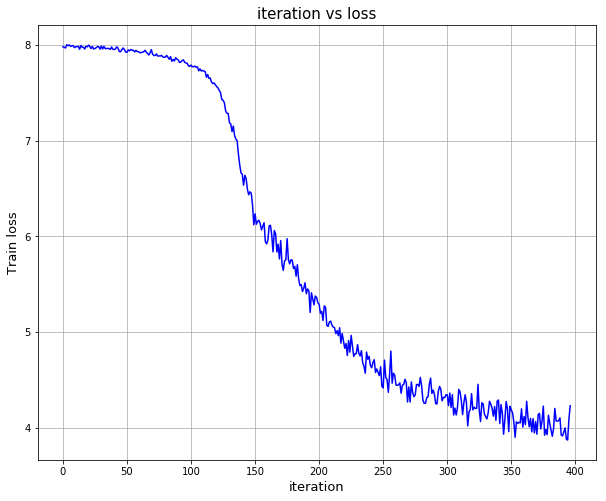

 1/40 [..............................] - ETA: 3942s - train loss: 5.8137 - dev loss: 4.0054 
Validation loss improved, Save Model!
398/396 [==============================] - 82s - train loss: 3.1916


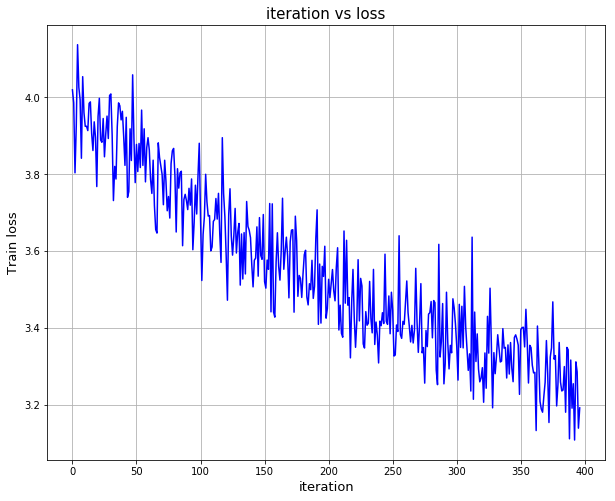

 2/40 [>.............................] - ETA: 3797s - train loss: 3.5495 - dev loss: 3.2690 
Validation loss improved, Save Model!
398/396 [==============================] - 82s - train loss: 2.9291


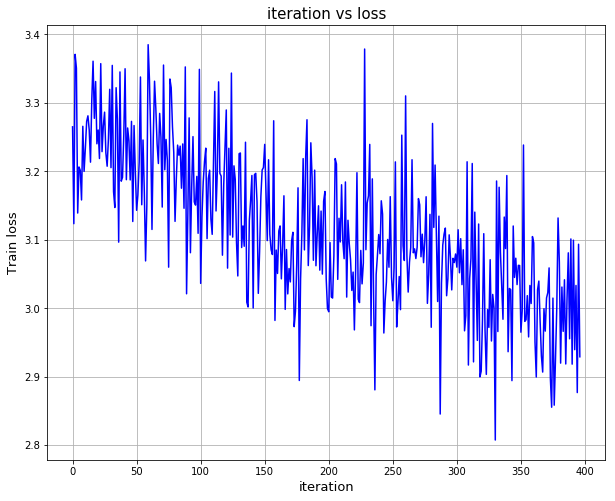

 3/40 [=>............................] - ETA: 3693s - train loss: 3.1175 - dev loss: 3.0239 
Validation loss improved, Save Model!
398/396 [==============================] - 81s - train loss: 2.8614


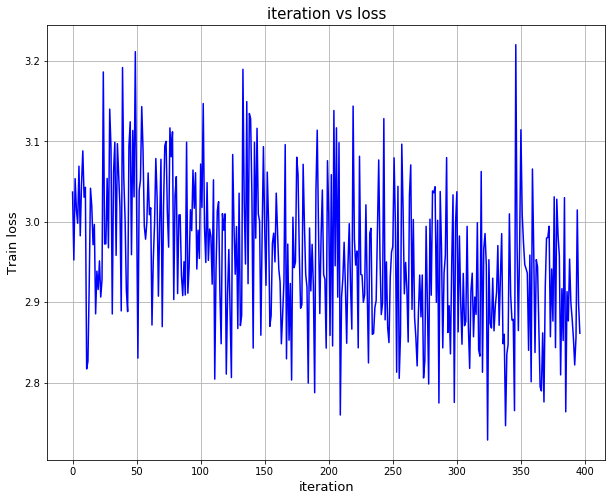

 4/40 [==>...........................] - ETA: 3581s - train loss: 2.9564 - dev loss: 2.9796 
Validation loss improved, Save Model!
398/396 [==============================] - 82s - train loss: 2.7568


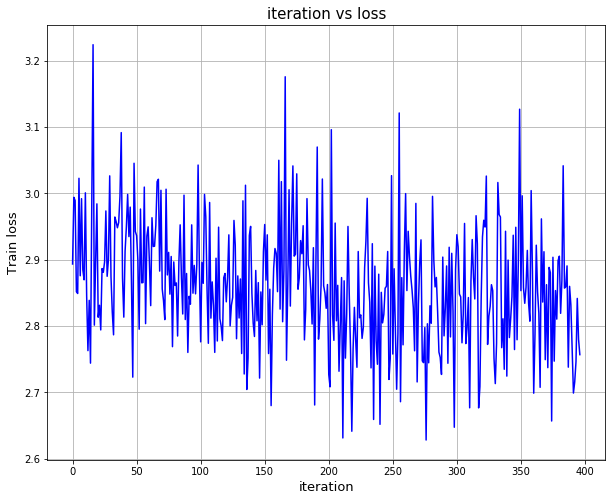

 5/40 [==>...........................] - ETA: 3491s - train loss: 2.8616 - dev loss: 2.9439 
Validation loss improved, Save Model!
398/396 [==============================] - 83s - train loss: 2.8515


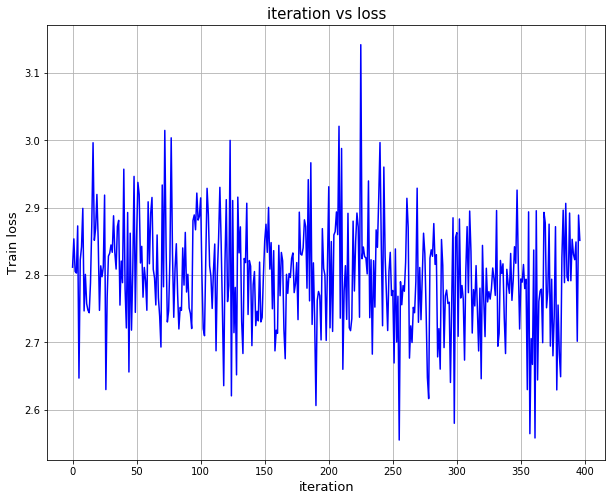

 6/40 [===>..........................] - ETA: 3360s - train loss: 2.7989 - dev loss: 2.9832 
Validation loss doesn't improve
398/396 [==============================] - 82s - train loss: 2.7514


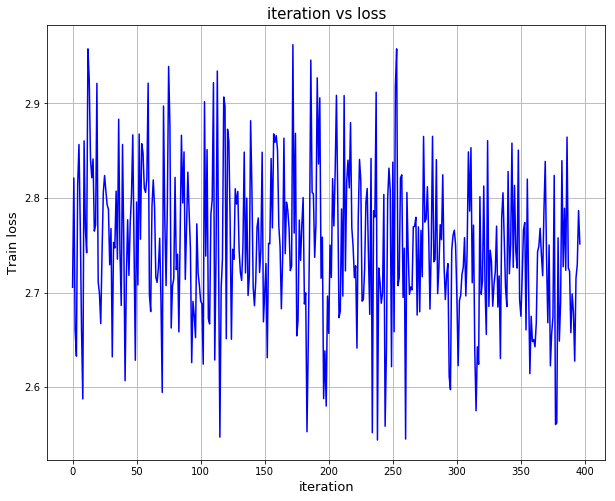

 7/40 [====>.........................] - ETA: 3236s - train loss: 2.7493 - dev loss: 2.9625 
Validation loss doesn't improve
398/396 [==============================] - 83s - train loss: 2.8295


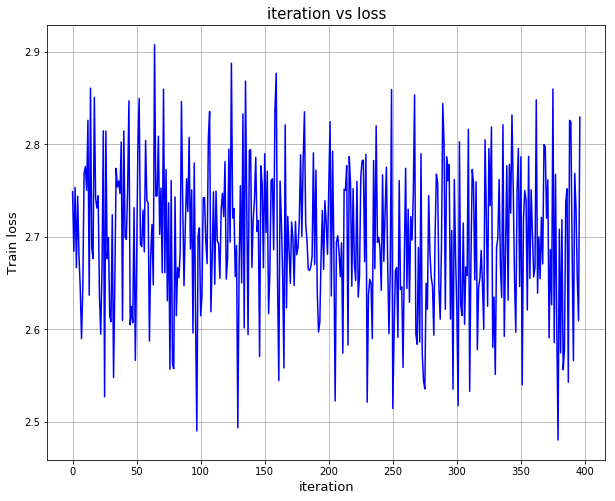

 8/40 [=====>........................] - ETA: 3124s - train loss: 2.6976 - dev loss: 2.9839 
Validation loss doesn't improve
398/396 [==============================] - 83s - train loss: 2.6514


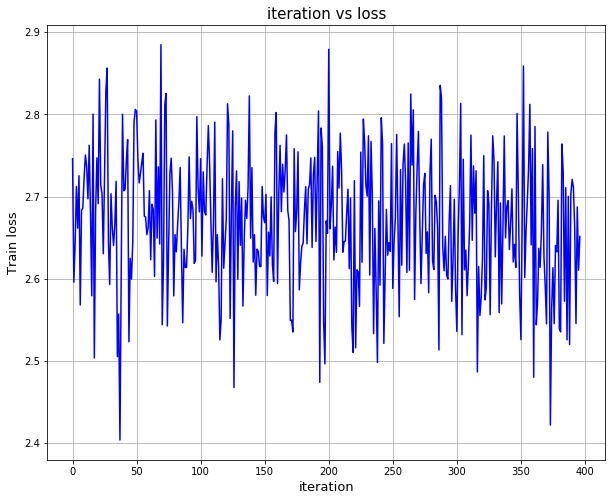

 9/40 [=====>........................] - ETA: 3015s - train loss: 2.6692 - dev loss: 3.0147 
Validation loss doesn't improve
398/396 [==============================] - 83s - train loss: 2.6870


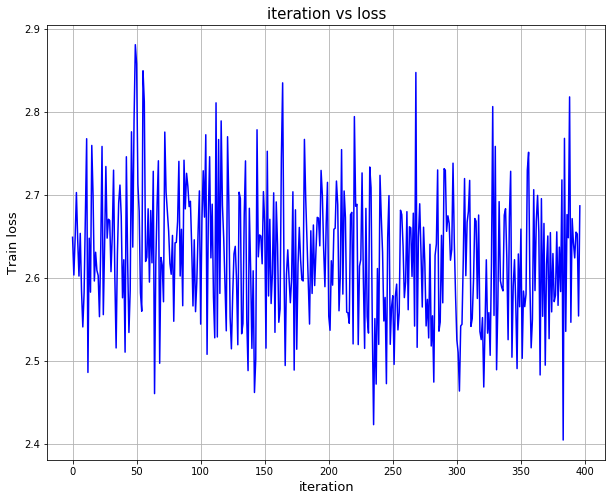

10/40 [======>.......................] - ETA: 2911s - train loss: 2.6262 - dev loss: 3.0193 
Validation loss doesn't improve
398/396 [==============================] - 84s - train loss: 2.6727


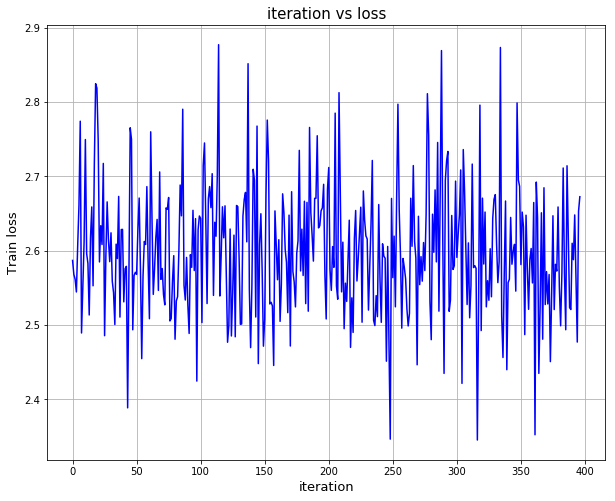

11/40 [=======>......................] - ETA: 2810s - train loss: 2.6001 - dev loss: 3.0730 
Validation loss doesn't improve
231/396 [================>.............] - ETA: 35s - train loss: 2.6078

KeyboardInterrupt: 

In [104]:
# run training mode
# saver = tf.train.Saver()

with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    out = model.train(sess, (input_frames_train, captions_train), verbose = True)


In [90]:
val_loss, tr_loss, tr_pred, val_pred, train_vid, val_vid = out

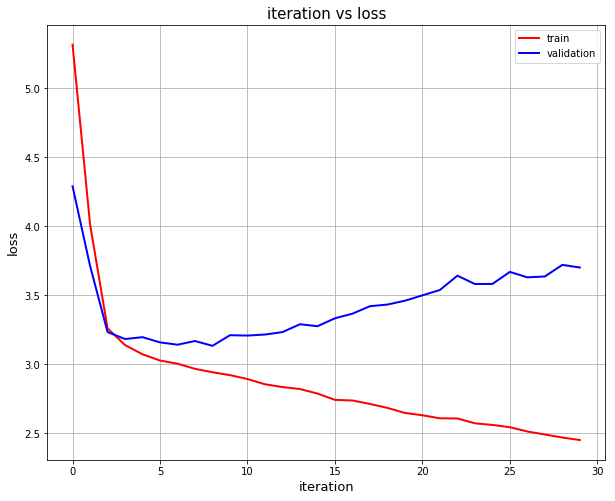

In [91]:
# plot learning curve
plt.plot(range(len(tr_loss)), tr_loss, 'r-', linewidth = 2, label = 'train')
plt.plot(range(len(val_loss)), val_loss, 'b-', linewidth = 2, label = 'validation')
plt.grid()
plt.xlabel('iteration', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('iteration vs loss', fontsize = 15)
plt.legend()
plt.savefig(os.getcwd() + '/output/CoCo_image_caption_learning_curve.png')
# plt.savefig(os.getcwd() + '/output/CoCo_seq2seq_learning_curve.png')

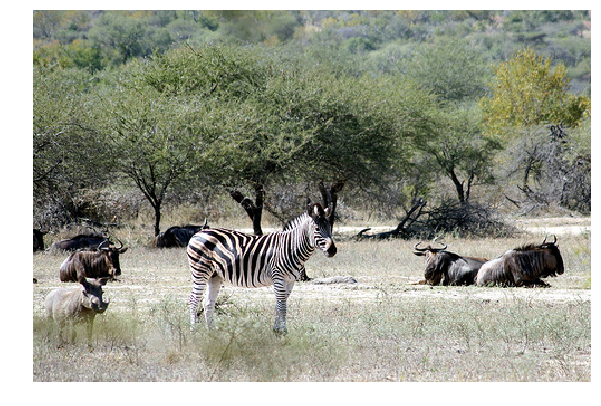

Pred Caption:  <START> two zebra of zebras are in in the field <END>
True Caption:  <START> a zebra looking <UNK> at something by a <UNK> <UNK> and <UNK> <END>
--------------------------------------------------


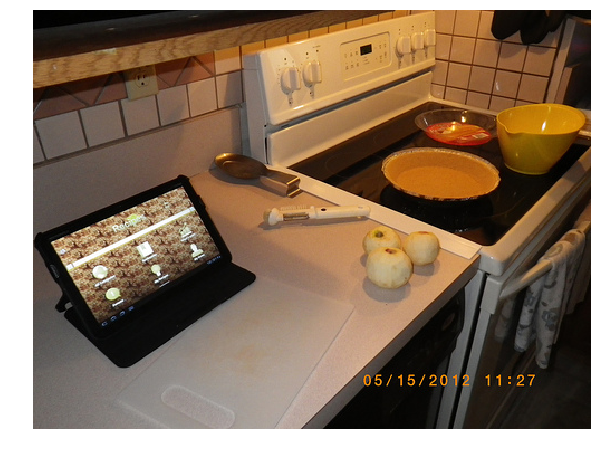

Pred Caption:  <START> a bathroom with with a a a a <UNK> <UNK> <UNK> <UNK> <END>
True Caption:  <START> a food <UNK> area with a <UNK> computer beside it <END>
--------------------------------------------------


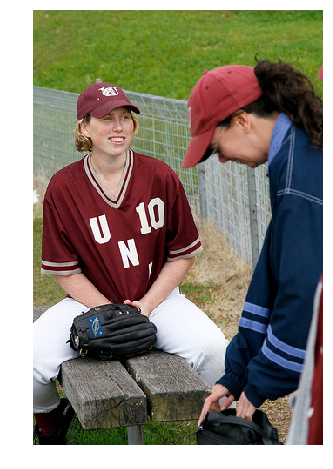

Pred Caption:  <START> a man boy a a red and a a <END>
True Caption:  <START> there is a woman <UNK> ball player sitting on a bench <END>
--------------------------------------------------
Pred Caption:  <START> a woman in a <UNK> of a a a pizza <END>
True Caption:  <START> a man is cutting into a baked pie inside <END>
--------------------------------------------------
Pred Caption:  <START> a <UNK> <UNK> <UNK> <UNK> <UNK> a <UNK> <UNK> <END>
True Caption:  <START> containers of multiple colored small tomatoes are seen <END>
--------------------------------------------------
Pred Caption:  <START> two people on down down a snow mountain <END>
True Caption:  <START> a <UNK> rides in to the ocean <END>
--------------------------------------------------
Pred Caption:  <START> a train and white train on a train a a train <END>
True Caption:  <START> a very old <UNK> on an old train parked in a yard <END>
--------------------------------------------------
Pred Caption:  <START> a woman wit

In [93]:
# list_video_index, list_predict_index = out

captions = captions_train
train_urls = data['train_urls']
# caption check
for j in range(len(val_pred)):
    words = []
    trues = []
    sample = val_pred[j]
    vid = val_vid[j]
    cap = captions[vid]
    for idx, i in enumerate(sample):
        word = index2word[i]
        true = index2word[cap[idx]]
        
        if word not in ['<NULL>']:
            words.append(word)
        if true not in ['<NULL>']:
            trues.append(true) 
        
    if j<3: 
        url = train_urls[int(vid)]
        plt.imshow(image_from_url(url))
        plt.axis('off')
        plt.show()
    print('Pred Caption: ', ' '.join(w for w in words))
    print('True Caption: ', ' '.join(t for t in trues))
    print('-'*50)

# TestSet

val_features....\class 'numpy.ndarray'\....   (40504, 4096) float32  
val_captions....\class 'numpy.ndarray'\....   (195954, 17) int32   
val_image_idxs....\<class 'numpy.ndarray'\....   (195954,) int32   
val_urls class....\'numpy.ndarray'\....   (40504,) <U63   

train_features....\class 'numpy.ndarray'\....   (82783, 4096) float32    
train_captions....\class 'numpy.ndarray'\....   (1000, 17) int32   
train_image_idxs....\class 'numpy.ndarray'\....   (1000,) int32   
train_urls....\class 'numpy.ndarray'\....   (82783,) <U63      

idx_to_word....\class 'list'\....   1004   
word_to_idx....\class 'dict'\....   1004   


In [16]:
val_features = data['val_features']
val_captions = data['val_captions']
val_image_idxs = data['val_image_idxs']
val_urls = data['val_urls']

# Extract test set 
n = 5
val_features_dict = {}
val_captions_dict = {}
val_urls_dict = {}
val_image_idxs_dictKeys = []

# for i,vid in enumerate(val_image_idxs):
#     if i>=n: break
#     val_captions_dict[vid] = val_captions[i]
#     val_features_dict[vid] = val_features[vid].reshape((1,-1))
#     val_urls_dict[vid] = val_urls[vid]
#     val_image_idxs_dictKeys.append(vid)

for i,vid in enumerate(val_image_idxs):
    if i>=n: break
    vid_pseudo = val_image_idxs[n-1-i]
    
    val_captions_dict[vid] = val_captions[i]
    val_features_dict[vid] = val_features[vid_pseudo].reshape((1,-1))
    val_urls_dict[vid] = val_urls[vid_pseudo]
    val_image_idxs_dictKeys.append(vid)


# Predict testset

In [94]:
with get_session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, os.getcwd() + "/model/COCO.ckpt")
    out = model.predict(sess, val_features_dict, val_captions_dict)

INFO:tensorflow:Restoring parameters from /home/sunjiajun/cs231n_project/model/COCO.ckpt


INFO:tensorflow:Restoring parameters from /home/sunjiajun/cs231n_project/model/COCO.ckpt
100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


In [95]:
list_video_index, list_predict_index = out

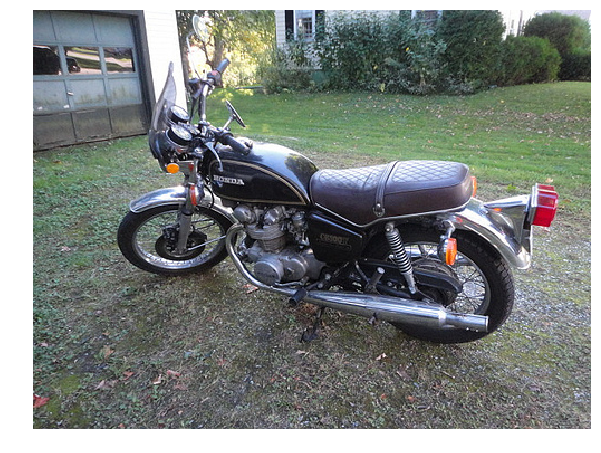

Pred Caption:  <START> a <UNK> <UNK> on the <UNK> the a <UNK> <END> <END>
true Caption:  <START> a car that <UNK> to be parked <UNK> behind a <UNK> parked car <END>
--------------------------------------------------


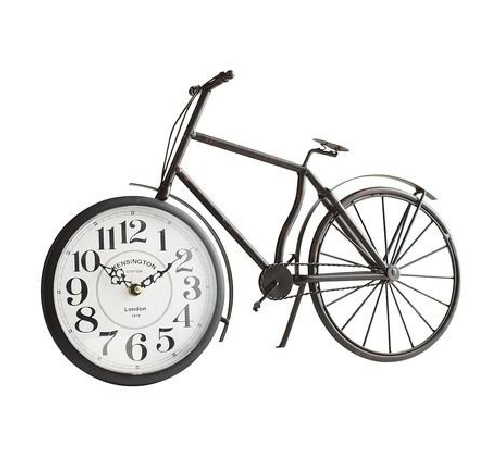

Pred Caption:  <START> a people of is a a a a a <END> <END>
true Caption:  <START> a large passenger airplane flying through the air <END>
--------------------------------------------------


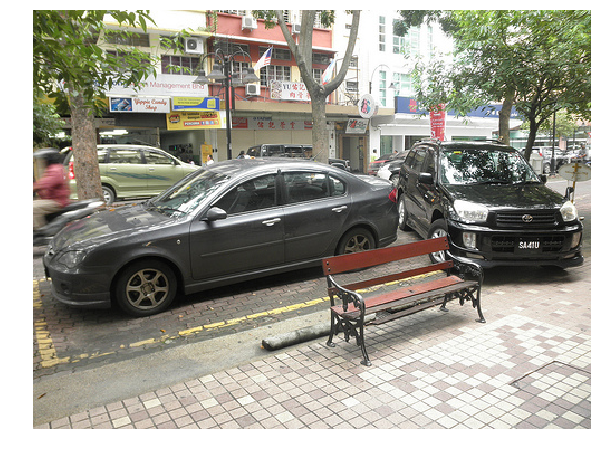

Pred Caption:  <START> a <UNK> parked on a a a <END> <END>
true Caption:  <START> a black <UNK> motorcycle parked in front of a <UNK> <END>
--------------------------------------------------


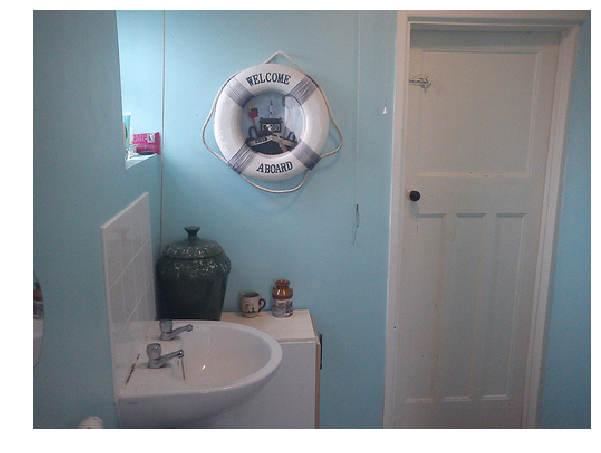

Pred Caption:  <START> a bathroom bathroom a a a a <END>
true Caption:  <START> a room with blue walls and a white sink and door <END>
--------------------------------------------------


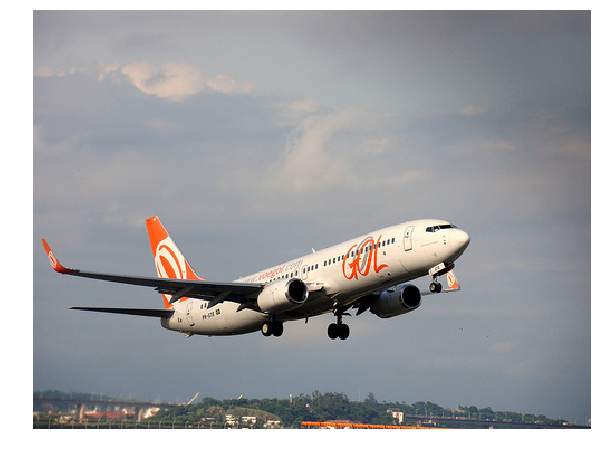

Pred Caption:  <START> a small <UNK> is <UNK> the <UNK> the <END> <END>
true Caption:  <START> a bicycle <UNK> with a clock as the front <UNK> <END>
--------------------------------------------------


In [96]:
for i, v_id in enumerate( list_video_index ):
    url = val_urls_dict[v_id]

    caption_pre = []
    for ind in list_predict_index[0][i]:
        word = index2word[ind]       
        if word not in ['<NULL>']:
            caption_pre.append(word)
            
    caption_true = []
    for ind in val_captions_dict[v_id]:
        word = index2word[ind]       
        if word not in ['<NULL>']:
            caption_true.append(word)
            
            
    plt.imshow(image_from_url(url))
    plt.axis('off')
    plt.show()
    print('Pred Caption: ', ' '.join(w for w in caption_pre))
    print('true Caption: ', ' '.join(w for w in caption_true))

    print('-'*50)



# Look At Data

In [ ]:


url = train_urls[vid]
plt.imshow(image_from_url(url))
plt.axis('off')
caption_str = decode_captions(caption, data['idx_to_word'])
plt.title(caption_str)
plt.show()

# # Sample a minibatch and show the images and captions
# batch_size = 1
# captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
# for i, (caption, url) in enumerate(zip(captions, urls)):
#     plt.imshow(image_from_url(url))
#     plt.axis('off')
#     caption_str = decode_captions(caption, data['idx_to_word'])
#     plt.title(caption_str)
#     plt.show()